In [1]:
from iros.io import fetch_simulation
from iros.mask import fetch_camera, encode, decode, count
from iros.images import compose, argmax

from iros.assets import path_wfm_mask

import numpy as np

In [2]:

sdl = fetch_simulation("../../simulations/id00/")
wfm = fetch_camera(path_wfm_mask, (5, 8))

detector_1a = count(wfm, sdl.detected["cam1a"])
balanced_1a = decode(wfm, detector_1a)

detector_1b = count(wfm, sdl.detected["cam1b"])
balanced_1b = decode(wfm, detector_1b)

composed, composed_f = compose(balanced_1a, balanced_1b)
max_composed = argmax(composed)
max_balanced_1a, max_balanced_1b = composed_f(*max_composed)

The reconstructed data may contain events with same ID and different SUBID.

In [4]:
ys_r = np.array([])
ys_d = np.array([])

for sim in [
    "/home/deppep/Documents/wfm_sims/id00",
    "/home/deppep/Documents/wfm_sims/id08",
    "/home/deppep/Documents/wfm_sims/id09",
    "/home/deppep/Documents/wfm_sims/id10",
    "/home/deppep/Documents/wfm_sims/id11",
    "/home/deppep/Documents/wfm_sims/id12",
]:
    print(f"onto data from {sim}")
    sdl = fetch_simulation(sim)

    rec = sdl.reconstructed["cam1a"]
    det = sdl.detected["cam1a"]

    rec_sorted_id = rec[rec["ID"].argsort()]
    det_sorted_id = det[det["ID"].argsort()]

    u, c = np.unique(rec["ID"], return_counts=True)
    rec_unique_ids = u[c == 1]
    det_ids = np.unique(det["ID"])
    selected_ids = np.intersect1d(rec_unique_ids, det_ids)

    rec_sorted_unique = rec_sorted_id[np.isin(rec_sorted_id["ID"], selected_ids)]
    det_sorted_unique = det_sorted_id[np.isin(det_sorted_id["ID"], selected_ids)]

    ys_d = np.concatenate((ys_d, det_sorted_unique["Y"]))
    ys_r = np.concatenate((ys_r, rec_sorted_unique["Y"]))


onto data from /home/deppep/Documents/wfm_sims/id00
onto data from /home/deppep/Documents/wfm_sims/id08
onto data from /home/deppep/Documents/wfm_sims/id09
onto data from /home/deppep/Documents/wfm_sims/id10
onto data from /home/deppep/Documents/wfm_sims/id11
onto data from /home/deppep/Documents/wfm_sims/id12


In [60]:
from functools import partial
from scipy.integrate import trapezoid


params_psfx = {
    "center": 0,
    "alpha": 0.0016,
    "beta": 0.6938,
}

params_psfy = {
    "center": 0,
    "alpha": 0.3214,
    "beta": 0.6246,
}


def modsech(x, norm, center, alpha, beta):
    return norm / np.cosh(np.abs((x - center) / alpha) ** beta)

psfx = partial(modsech, norm=1., **params_psfx)
psfy = partial(modsech, norm=1., **params_psfy)

def norm_constant(center, alpha, beta):
    xs = np.linspace(-50*alpha, +50*alpha, 10000)
    return 1 / trapezoid(
        y = modsech(xs, norm=1, center=center, alpha=alpha, beta=beta),
        x = xs,
    )

def norm_modsech(center, alpha, beta):
    norm = norm_constant(center, alpha, beta)
    return partial(modsech, norm=norm, center=center, alpha=alpha, beta=beta)

norm_psfx = norm_modsech(**params_psfx)
norm_psfy = norm_modsech(**params_psfy)

In [61]:
bins = np.linspace(-10, 10, 10001)
midpoints = (bins[1:] + bins[:-1]) / 2
counts, _ = np.histogram(ys_r - ys_d, bins=bins, density=True)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

ma = moving_average(counts, 10)

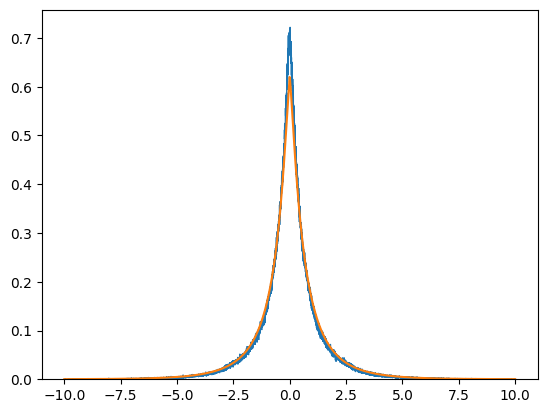

In [62]:
import matplotlib.pyplot as plt

plt.stairs(counts, edges=bins)
plt.plot(midpoints, norm_psfy(midpoints))
plt.show()

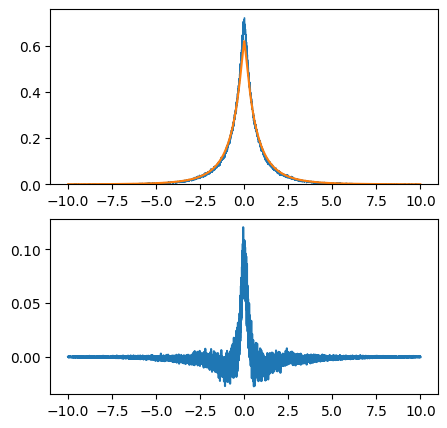

In [63]:
fig, axs = plt.subplots(2, 1, figsize = (5, 5))
axs[0].stairs(counts, edges=bins)
axs[0].plot(midpoints, norm_psfy(midpoints))
axs[1].plot(midpoints, counts - norm_psfy(midpoints))
plt.show()

In [73]:
from scipy.optimize import curve_fit

res = curve_fit(
    f = lambda xs, alpha, beta: norm_modsech(0, alpha, beta)(xs),
    xdata=midpoints,
    ydata=counts
)

best_fit = norm_modsech(0, *res[0])
print(f"best fit parameters: alpha={res[0][0]}, beta={res[0][1]}")

best fit parameters: alpha=0.2592319088817486, beta=0.5972963324935765


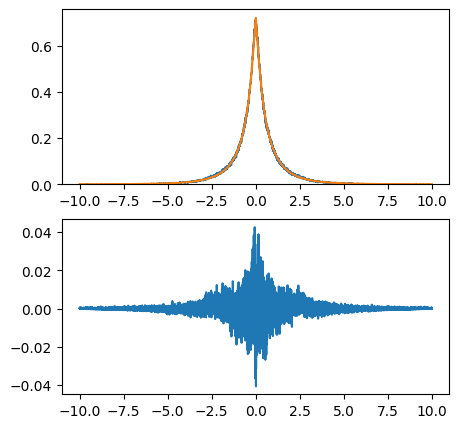

In [74]:
fig, axs = plt.subplots(2, 1, figsize = (5, 5))
axs[0].stairs(counts, edges=bins)
axs[0].plot(midpoints, best_fit(midpoints))
axs[1].plot(midpoints, counts - best_fit(midpoints))
plt.show()